# Retrieving data from the current widget's view

So far, we've seen how to send information (tables, MOCs, ...) into the widget. The other way also works! This notebook contains a list of methods to extract diverse information about the current view. However, here are several information about retrieving data from the widget:

- when the view is modified programmatically (*i.e.* not by clicking on the buttons), the update of its properties is done between cell execution. This means that you'll see a `WidgetNotReadyError` when you try to modify the view and retrieve information about it in the **same** cell. Simply switch the property-reading to the next cell and everything will work as intended!
- if you generate different views of the same `Aladin()` instances -- either by calling `display` multiple times, or by using the `Create new view for cell output` button in Jupyter, the information contained in `wcs` and `fov_xy` will always correspond to the **most recently** created view.

In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt
import numpy as np

from ipyaladin import Aladin

In [2]:
aladin = Aladin(fov=5, height=600, target="M31")
aladin

Aladin()

## Getting the current WCS

The World Coordinates System (WCS) describes the field of view, the projection, and it's rotation. It is returned as an `astropy.coordinates.WCS` object.

In [3]:
aladin.wcs  # Recover the current WCS

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN' 'DEC--SIN' 
CRVAL : 10.684708330000005 41.26875 
CRPIX : 658.5 300.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00379939209726443 0.003799392097264438 
NAXIS : 1316  600

If you edit the view either by modifiing the widget through its interface, or programmatically:

In [4]:
aladin.height = 800
aladin.survey = "CDS/P/PLANCK/R2/HFI/color"
aladin.target = "LMC"
aladin.frame = "Galactic"
aladin.fov = 50

The wcs is updated and you can print its new value in the **next cell**:

In [5]:
aladin.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN' 'DEC--SIN' 
CRVAL : 80.89416667 -69.75611110999999 
CRPIX : 649.5 400.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.03852080123266564 0.03852080123266564 
NAXIS : 1298  800

If you try to recover the value in the **same cell**, you'll get a `WidgetCommunicationError` error. This is because the calculation of the WCS is done by Aladin Lite *between* cell executions.

## Getting the field of view

The field of view is printed in the bottom left corner of the view. You can grab the two values with:

In [6]:
aladin.fov_xy  # Recover the current field of view for the x and y axis

(<Angle 50. deg>, <Angle 30.81664099 deg>)

## Getting the selection
First, load two catalogs:

In [7]:
m1 = SkyCoord.from_name("m1")

# if these don't work, do `pip install astroquery -U --pre`
simbad = Simbad.query_region(m1, radius=0.1 * u.deg)
usno = Vizier(catalog="I/284/out", row_limit=-1).query_region(m1, radius=0.05 * u.deg)[
    0
]

In [8]:
aladin.add_table(simbad, name="simbad", color="purple", shape="circle", source_size=20)
aladin.add_table(usno, name="usno", color="teal", shape="square", source_size=20)
aladin.target = m1
aladin.fov = 0.3
aladin.survey = "CDS/P/PanSTARRS/DR1/g"

After that, select a region in the Aladin Lite widget (you can also trigger a selection with `right click` then `select sources`):

In [9]:
aladin.selection("circle")

Then, you can recover the selection as a list of astropy.Table objects with:

In [10]:
aladin.selected_objects

[]

## Getting the view as a fits file
The following method allow you to retrieve the current view as a fits file.

In [11]:
fits = aladin.get_view_as_fits()

In [12]:
fits[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1298                                                  
NAXIS2  =                  800                                                  
NAXIS3  =                    3                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                649.5 / Pixel coordinate of reference point            
CRPIX2  =                400.5 / Pixel coordinate of reference point            
CDELT1  = -0.00023112480739599 / [deg] Coordinate increment at reference point  
CDELT2  =  0.00023112480739599 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'             

Display the fits file using matplotlib:

In [ ]:
wcs = WCS(fits[0].header)

plt.subplot(projection=wcs)
plt.imshow(fits[0].data, cmap="binary_r", norm="asinh", vmin=0.001)

## Saving the view as an image file

`save_view_as_image` takes a screenshot of the widget. The first argument is the path where the file should be written, the second is the format ("png", "jpeg", "webp"), and the third is a boolean to indicate if you want to include the Aladin Lite logo in the image. 
These data are reflecting the pixels on the screen. For scientific use cases, opt for `get_view_as_fits` that is a bit longer since it retrieves the actual survey from a server.

In [14]:
screenshot_wcs = aladin.wcs
aladin.save_view_as_image(path="./images/crab.png", image_format="png", with_logo=True)

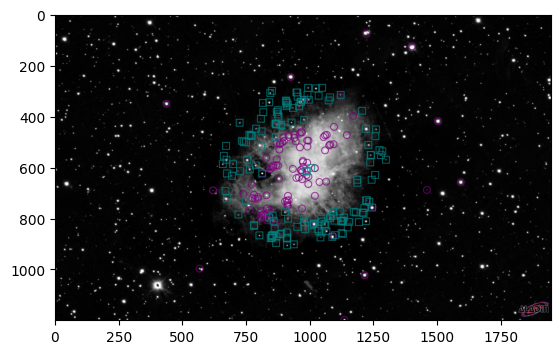

In [15]:
img = plt.imread("./images/crab.png")
plt.imshow(img)

And with the WCS that we stored at the same time than the screenshot

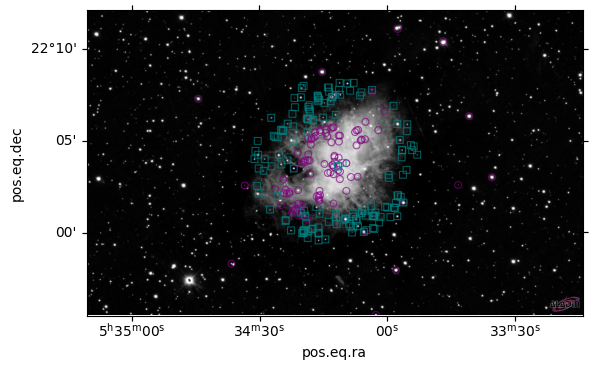

In [16]:
img = plt.imread("./images/crab.png")
plt.subplot(projection=screenshot_wcs)
# in FITS, the lines of pixels are flipped, so we have to mimic this
plt.imshow(np.flipud(img))